In [1]:
from Oanda_Data import OandaData
from ENGINE.DATALAKE.TIMESERIES.OHLC_Manipulate import OHLC_DF_to_REGRESSION_C, OHLC_DF_to_CLASSIFICATION_C
from ENGINE.DATALAKE.TIMESERIES.Data_to_PytorchForecasting import DF_to_TSDataSet
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [2]:
OD = OandaData()
data = OD.GetData("2020-01-01T00:00:00Z", "2021-04-21T00:00:00Z", "EUR_USD", "M15", "DF")
df = OHLC_DF_to_REGRESSION_C(data)
training, train_dataloader, val_dataloader = DF_to_TSDataSet(df,max_encoder_length=60,max_prediction_length=1)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

In [3]:
baseline_predictions = Baseline().predict(val_dataloader)
value = SMAPE()(baseline_predictions, actuals)
print(value)

tensor(0.0002)


In [4]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=15,
    # limit_val_batches=1,
    # fast_dev_run=True,
    # logger=logger,
    # profiler=True,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [5]:
net = NBeats.from_dataset(
    training, learning_rate=0.0014125375446227544, log_interval=10, log_val_interval=1, log_gradient_flow=False, weight_decay=1e-2
)
print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

Number of parameters in network: 1683.6k


In [6]:
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.735     Total estimated model params size (MB)


1

In [7]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [8]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
value = (actuals - predictions).abs().mean()
print(value)

tensor(0.0001)


In [9]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

In [10]:
raw_predictions

{'prediction': tensor([[1.2033],
         [1.2033]]),
 'target_scale': tensor([[1.2042e+00, 1.1647e-03],
         [1.2041e+00, 1.1075e-03]]),
 'backcast': tensor([[-0.5622, -0.5632, -0.5641, -0.5652, -0.5663, -0.5674, -0.5686, -0.5699,
          -0.5712, -0.5726, -0.5740, -0.5755, -0.5770, -0.5786, -0.5802, -0.5819,
          -0.5837, -0.5855, -0.5874, -0.5893, -0.5912, -0.5933, -0.5953, -0.5975,
          -0.5996, -0.6019, -0.6042, -0.6065, -0.6089, -0.6114, -0.6139, -0.6164,
          -0.6191, -0.6217, -0.6245, -0.6272, -0.6301, -0.6330, -0.6359, -0.6389,
          -0.6420, -0.6451, -0.6482, -0.6514, -0.6547, -0.6580, -0.6614, -0.6648,
          -0.6683, -0.6719, -0.6755, -0.6791, -0.6828, -0.6866, -0.6904, -0.6943,
          -0.6982, -0.7021, -0.7062, -0.7103],
         [-0.5677, -0.5680, -0.5683, -0.5687, -0.5692, -0.5698, -0.5704, -0.5710,
          -0.5717, -0.5725, -0.5733, -0.5742, -0.5752, -0.5762, -0.5772, -0.5784,
          -0.5795, -0.5808, -0.5821, -0.5834, -0.5848, -0.586

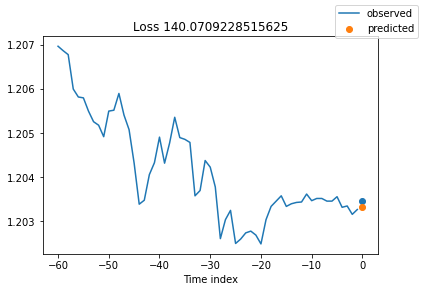

In [11]:
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [14]:
data_future = data = OD.GetData("2021-04-22T00:00:00Z", "2021-05-04T00:00:00Z", "EUR_USD", "M15", "DF")

In [16]:
df_future = OHLC_DF_to_REGRESSION_C(data_future)

In [19]:
df_future.insert(0,'series','True')

max_encoder_length = 60
max_prediction_length = 1

training_cutoff = df_future["time_idx"].max() - max_prediction_length
context_length = max_encoder_length
prediction_length = max_prediction_length

TSDS = TimeSeriesDataSet(
    df_future[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="pred",
    group_ids=["series"],
    time_varying_unknown_reals=["pred"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length)


In [21]:
batch_size = 1
val_dataloader = TSDS.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [22]:
val_dataloader

In [24]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
value = (actuals - predictions).abs().mean()
print(value)

tensor(0.0004)


In [26]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

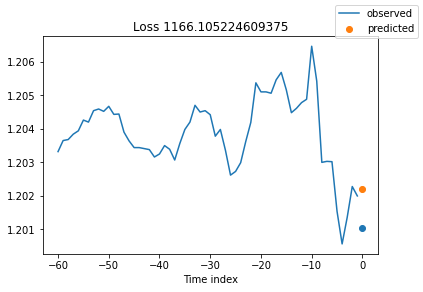

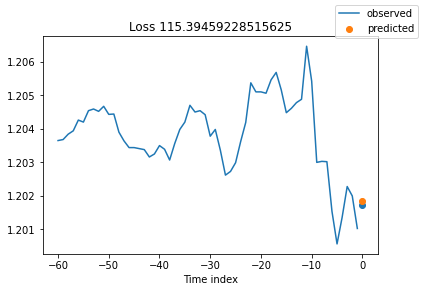

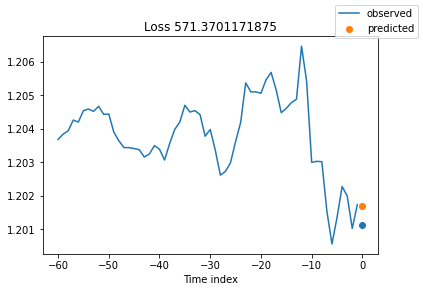

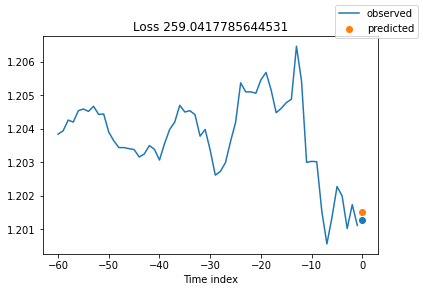

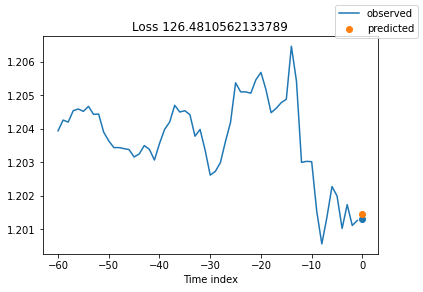

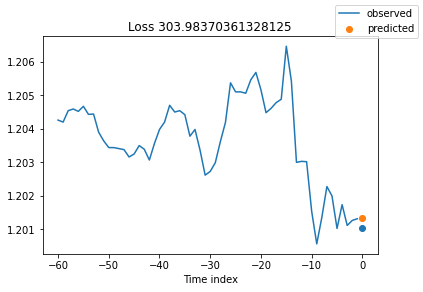

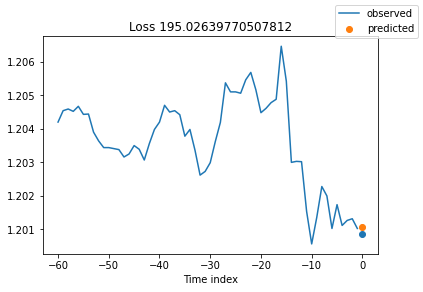

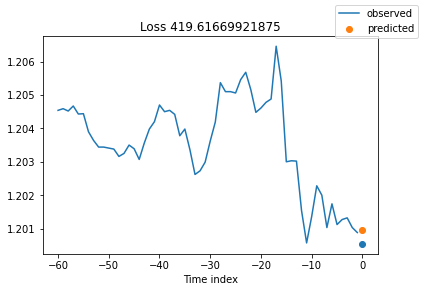

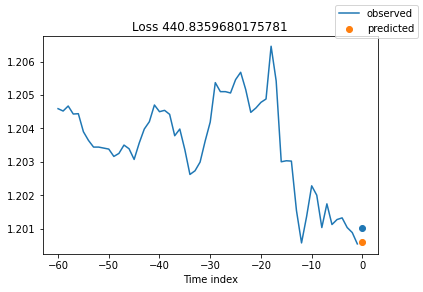

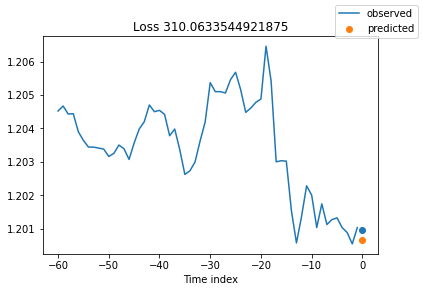

In [28]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [30]:
actuals

tensor([[1.2010],
        [1.2017],
        [1.2011],
        [1.2013],
        [1.2013],
        [1.2010],
        [1.2009],
        [1.2005],
        [1.2010],
        [1.2010],
        [1.2009],
        [1.1999],
        [1.2000],
        [1.2005],
        [1.2008],
        [1.2007],
        [1.2011],
        [1.2013],
        [1.2014],
        [1.2015],
        [1.2016],
        [1.2015],
        [1.2015],
        [1.2016],
        [1.2016],
        [1.2017],
        [1.2017],
        [1.2016],
        [1.2016],
        [1.2015],
        [1.2015],
        [1.2017],
        [1.2016],
        [1.2015],
        [1.2014],
        [1.2017],
        [1.2018],
        [1.2016],
        [1.2021],
        [1.2022],
        [1.2022],
        [1.2025],
        [1.2026],
        [1.2021],
        [1.2020],
        [1.2022],
        [1.2022],
        [1.2023],
        [1.2023],
        [1.2022],
        [1.2022],
        [1.2023],
        [1.2024],
        [1.2025],
        [1.2027],
        [1